<a href="https://colab.research.google.com/github/rajalingam24/Emotion-Detection/blob/main/Custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries

import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/fer2013.csv'

df = pd.read_csv(dataset_path)

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

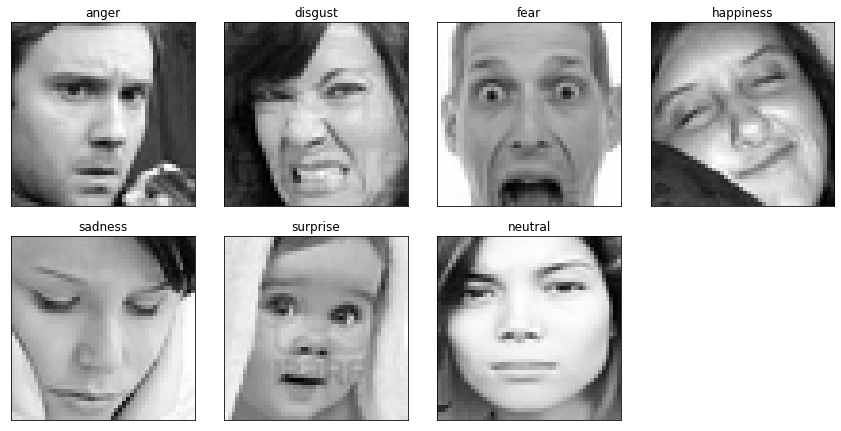

In [ ]:
# Visualizing the datasets

emotions_dummy = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (12, 12))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(4, 4, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_dummy[label])
        plt.tight_layout()

In [ ]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset(data):
    data = (data[data['pixels'].notnull()])
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        face = cv2.cvtColor(face, cv2.COLOR_GRAY2BGR)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [ ]:
train_data = df.loc[df['Usage']=='Training']      # Training Data
valid_data = df.loc[df['Usage']=='PublicTest']    # Validation Data
test_data  = df.loc[df['Usage']=='PrivateTest']   # Test Data

print (len(train_data), len (valid_data), len(test_data))  # Printing the len of all the data

28709 3589 3589


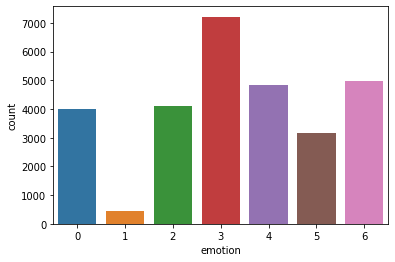

In [ ]:
import seaborn as sns
sns.countplot(data=train_data, x = 'emotion')
plt.show()

In [ ]:
# Training Data - Extraction & Pre-Processing

X_train, Y_train = load_dataset(train_data)
#X_train = preprocess_data(X_train)
Y_train = to_categorical(Y_train)
    
print("Shape of X_Train = {}".format(X_train.shape))
print("Shape of Y_Train = {}".format(Y_train.shape))

Shape of X_Train = (28709, 48, 48, 3)
Shape of Y_Train = (28709, 7)


In [ ]:
# PublicTest / Validation Data - Extraction & Pre-Processing

X_val, Y_val = load_dataset(valid_data)
#X_val = preprocess_data(X_val)
Y_val = to_categorical(Y_val)

print("Shape of X_Val = {}".format(X_val.shape))
print("Shape of Y_Val = {}".format(Y_val.shape))

Shape of X_Val = (3589, 48, 48, 3)
Shape of Y_Val = (3589, 7)


In [ ]:
# PrivateTest / Evaluation Data - Extraction & Pre-Processing

X_eval, Y_eval = load_dataset(test_data)
#X_eval = preprocess_data(X_eval)
Y_eval = to_categorical(Y_eval)

print("Shape of X_Eval = {}".format(X_eval.shape))
print("Shape of Y_Eval = {}".format(Y_eval.shape))

Shape of X_Eval = (3589, 48, 48, 3)
Shape of Y_Eval = (3589, 7)


In [ ]:
# Defining Train and Test ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255) #, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255,featurewise_center=False, featurewise_std_normalization=False, rotation_range=10, 
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)

In [ ]:
import tensorflow as tf
from keras import regularizers
model = tf.keras.models.Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(7, activation='softmax'))

    #Compliling the model
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
chk_path = 'ferNetweight.h5'
#log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)




callbacks = [checkpoint, reduce_lr,earlystop]

In [ ]:
batch_size=128

In [ ]:
istory = model.fit(X_train, Y_train, batch_size = 128, epochs = 50, verbose=1,validation_data = (X_val, Y_val),callbacks=callbacks)

Epoch 1/50
225/225 [==============================] - 74s 185ms/step - loss: 12.6452 - accuracy: 0.2598 - val_loss: 12.4668 - val_accuracy: 0.2126

Epoch 00001: val_loss improved from inf to 12.46677, saving model to ferNetweight.h5
Epoch 2/50
225/225 [==============================] - 40s 179ms/step - loss: 10.7908 - accuracy: 0.3424 - val_loss: 9.9356 - val_accuracy: 0.3990

Epoch 00002: val_loss improved from 12.46677 to 9.93557, saving model to ferNetweight.h5
Epoch 3/50
225/225 [==============================] - 41s 181ms/step - loss: 9.0891 - accuracy: 0.3920 - val_loss: 8.2697 - val_accuracy: 0.4310

Epoch 00003: val_loss improved from 9.93557 to 8.26966, saving model to ferNetweight.h5
Epoch 4/50
225/225 [==============================] - 41s 182ms/step - loss: 7.5784 - accuracy: 0.4277 - val_loss: 6.8942 - val_accuracy: 0.4589

Epoch 00004: val_loss improved from 8.26966 to 6.89416, saving model to ferNetweight.h5
Epoch 5/50
225/225 [==============================] - 41s 182ms

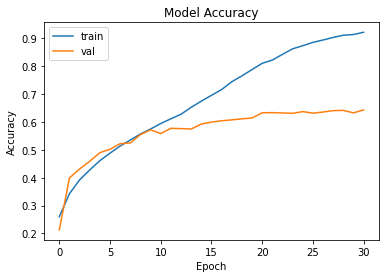

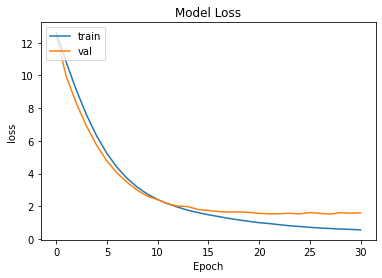

In [ ]:
# Plotting Performance Metrics


plt.plot(istory.history['accuracy'])
plt.plot(istory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(istory.history['loss'])
plt.plot(istory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_predcu = model.predict(X_val)
y_truecu = Y_val

y_truecu = np.argmax(y_truecu,axis=1)
y_predcu = np.argmax(y_predcu>0.5,axis=1)

from sklearn.metrics import classification_report
target_names =  ['Angry','disgust', 'fear', 'happy','sad','surprise', 'neutral']
print(classification_report(y_truecu, y_predcu, target_names=target_names))

              precision    recall  f1-score   support

       Angry       0.35      0.69      0.46       467
     disgust       0.90      0.50      0.64        56
        fear       0.58      0.41      0.48       496
       happy       0.85      0.80      0.83       895
         sad       0.59      0.46      0.52       653
    surprise       0.84      0.77      0.80       415
     neutral       0.58      0.53      0.55       607

    accuracy                           0.61      3589
   macro avg       0.67      0.59      0.61      3589
weighted avg       0.65      0.61      0.62      3589



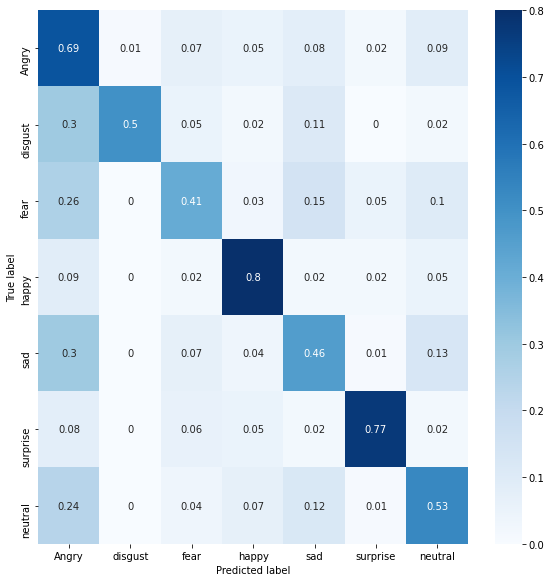

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_truecu, y_predcu)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_truecu, predictions=y_predcu).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)


import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_truecu, y_predcu, output_dict=True)
report = pd.DataFrame(report_dict)

report

,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.348913,0.903226,0.577586,0.848878,0.587084,0.836842,0.577899,0.614656,0.668633,0.652324
recall,0.687366,0.500000,0.405242,0.803352,0.459418,0.766265,0.525535,0.614656,0.592454,0.614656
f1-score,0.462870,0.643678,0.476303,0.825488,0.515464,0.800000,0.550475,0.614656,0.610611,0.621343
support,467.000000,56.000000,496.000000,895.000000,653.000000,415.000000,607.000000,0.614656,3589.000000,3589.000000


In [ ]:
y_predev = model.predict(X_eval)
y_trueev = Y_eval
y_trueev = np.argmax(y_trueev,axis=1)
y_predev = np.argmax(y_predev>0.5,axis=1)

from sklearn.metrics import classification_report
target_names = ['Angry','disgust', 'fear', 'happy','sad','surprise', 'neutral']
print(classification_report(y_trueev, y_predev, target_names=target_names))

              precision    recall  f1-score   support

       Angry       0.38      0.68      0.49       491
     disgust       0.91      0.56      0.70        55
        fear       0.61      0.44      0.51       528
       happy       0.86      0.82      0.84       879
         sad       0.54      0.44      0.48       594
    surprise       0.83      0.75      0.79       416
     neutral       0.64      0.63      0.63       626

    accuracy                           0.63      3589
   macro avg       0.68      0.62      0.63      3589
weighted avg       0.67      0.63      0.64      3589



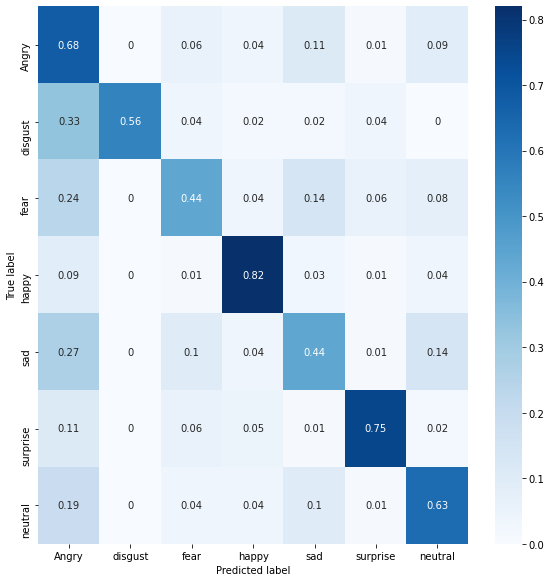

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_trueev, y_predev)
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(labels=y_trueev, predictions=y_predev).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = target_names, 
                                columns = target_names)


import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(y_trueev, y_predev, output_dict=True)
report = pd.DataFrame(report_dict)

report

,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.320179,0.750000,0.607784,0.894194,0.568182,0.846154,0.623140,0.604904,0.658519,0.664517
recall,0.727088,0.600000,0.384470,0.788396,0.336700,0.740385,0.602236,0.604904,0.597039,0.604904
f1-score,0.444583,0.666667,0.470998,0.837969,0.422833,0.789744,0.612510,0.604904,0.606472,0.613916
support,491.000000,55.000000,528.000000,879.000000,594.000000,416.000000,626.000000,0.604904,3589.000000,3589.000000
